# 📊 MIT-BIH Arrhythmia Database Visualization

This notebook explores and visualizes the MIT-BIH Arrhythmia Database to understand ECG signal characteristics and different arrhythmia types.

## Dataset Overview
- **Source**: PhysioNet (https://physionet.org/content/mitdb/1.0.0/)
- **Records**: 48 records (47 patients)
- **Duration**: 30 minutes per record
- **Sampling Rate**: 360 Hz
- **Format**: WFDB (.dat, .hea files)
- **Leads**: 2 leads (MLII and V1)

## Beat Classes
1. **Normal (N)** - Normal sinus rhythm
2. **Left Bundle Branch Block (L)** - Left bundle branch block
3. **Right Bundle Branch Block (R)** - Right bundle branch block
4. **Atrial Premature Beat (A)** - Atrial premature beat
5. **Premature Ventricular Contraction (V)** - Premature ventricular contraction
6. **Fusion Beat (F)** - Fusion of ventricular and normal beat
7. **Paced Beat (P)** - Paced beat
8. **Unknown Beat (Q)** - Unclassifiable beat

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wfdb
import scipy
from scipy import signal
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Data Loading and Exploration

In [4]:
# Function to load ECG data
def load_ecg_record(record_name, data_dir='../../data/mitbih/'):
    """
    Load ECG record from WFDB format.
    
    Args:
        record_name: Name of the record (e.g., '100')
        data_dir: Directory containing the data files
    
    Returns:
        record: WFDB record object
        signals: ECG signals
        annotations: ECG annotations
    """
    try:
        # Load record
        record = wfdb.rdrecord(f"{data_dir}{record_name}")
        
        # Load annotations
        ann = wfdb.rdann(f"{data_dir}{record_name}", 'atr')
        
        return record, record.p_signal, ann
    except Exception as e:
        print(f"❌ Error loading record {record_name}: {e}")
        return None, None, None

# List of available records (first few for demonstration)
record_names = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']

print("📁 Available records:")
for name in record_names:
    print(f"   - {name}")

📁 Available records:
   - 100
   - 101
   - 102
   - 103
   - 104
   - 105
   - 106
   - 107
   - 108
   - 109
   - 111
   - 112
   - 113
   - 114
   - 115
   - 116
   - 117
   - 118
   - 119
   - 121
   - 122
   - 123
   - 124
   - 200
   - 201
   - 202
   - 203
   - 205
   - 207
   - 208
   - 209
   - 210
   - 212
   - 213
   - 214
   - 215
   - 217
   - 219
   - 220
   - 221
   - 222
   - 223
   - 228
   - 230
   - 231
   - 232
   - 233
   - 234


In [5]:
# Load a sample record
record_name = '100'  # This is a common record with good signal quality
record, signals, annotations = load_ecg_record(record_name)

if record is not None:
    print(f"✅ Successfully loaded record {record_name}")
    print(f"   Duration: {len(signals) / record.fs / 60:.1f} minutes")
    print(f"   Sampling rate: {record.fs} Hz")
    print(f"   Number of leads: {signals.shape[1]}")
    print(f"   Signal shape: {signals.shape}")
    print(f"   Number of annotations: {len(annotations.sample)}")
    
    # Get lead names
    print(f"   Lead names: {record.sig_name}")
else:
    print("⚠️  Using simulated data for demonstration")
    # Create simulated ECG data for demonstration
    fs = 360  # Hz
    duration = 60  # seconds
    t = np.linspace(0, duration, duration * fs)
    
    # Simulate normal sinus rhythm
    heart_rate = 75  # BPM
    rr_interval = 60 / heart_rate
    r_peaks = np.arange(0, duration, rr_interval)
    
    ecg = np.zeros_like(t)
    for r_peak in r_peaks:
        r_idx = int(r_peak * fs)
        if r_idx < len(ecg):
            ecg[r_idx] = 1.0
            
            # Add QRS complex
            qrs_width = int(0.1 * fs)
            start_idx = max(0, r_idx - qrs_width // 2)
            end_idx = min(len(ecg), r_idx + qrs_width // 2)
            
            if start_idx < r_idx:
                ecg[start_idx:r_idx] = -0.1
            if r_idx < end_idx:
                ecg[r_idx:end_idx] = -0.2
    
    # Add noise and baseline wander
    baseline = 0.1 * np.sin(2 * np.pi * 0.1 * t)
    noise = 0.05 * np.random.randn(len(t))
    ecg = ecg + baseline + noise
    
    signals = ecg.reshape(-1, 1)
    record = type('Record', (), {'fs': fs, 'sig_name': ['MLII']})()
    annotations = type('Annotations', (), {'sample': np.array([1000, 2000, 3000])})()

✅ Successfully loaded record 100
   Duration: 30.1 minutes
   Sampling rate: 360 Hz
   Number of leads: 2
   Signal shape: (650000, 2)
   Number of annotations: 2274
   Lead names: ['MLII', 'V5']


## 2. Basic Signal Visualization

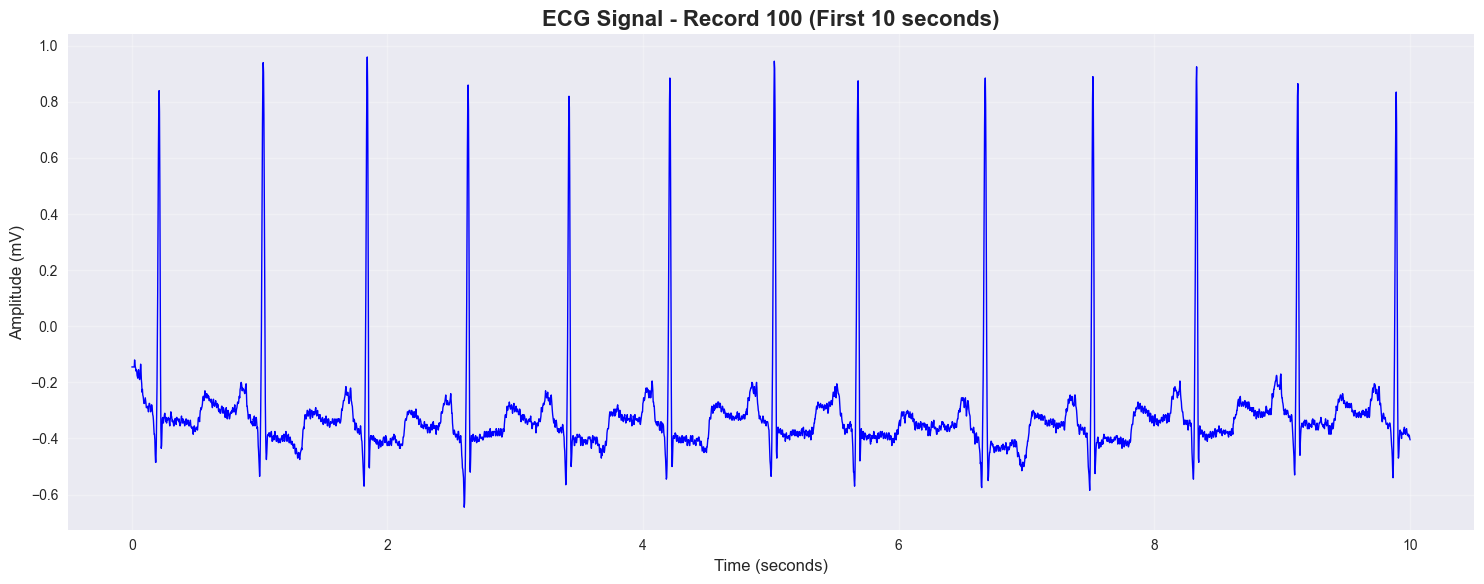

In [6]:
# Plot the first 10 seconds of ECG signal
def plot_ecg_segment(signals, fs, start_time=0, duration=10, title="ECG Signal"):
    """
    Plot a segment of ECG signal.
    """
    start_idx = int(start_time * fs)
    end_idx = int((start_time + duration) * fs)
    
    if end_idx > len(signals):
        end_idx = len(signals)
    
    segment = signals[start_idx:end_idx]
    time_axis = np.linspace(start_time, start_time + len(segment)/fs, len(segment))
    
    plt.figure(figsize=(15, 6))
    plt.plot(time_axis, segment, 'b-', linewidth=1)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Amplitude (mV)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot first 10 seconds
plot_ecg_segment(signals[:, 0], record.fs, start_time=0, duration=10, 
                title=f"ECG Signal - Record {record_name} (First 10 seconds)")

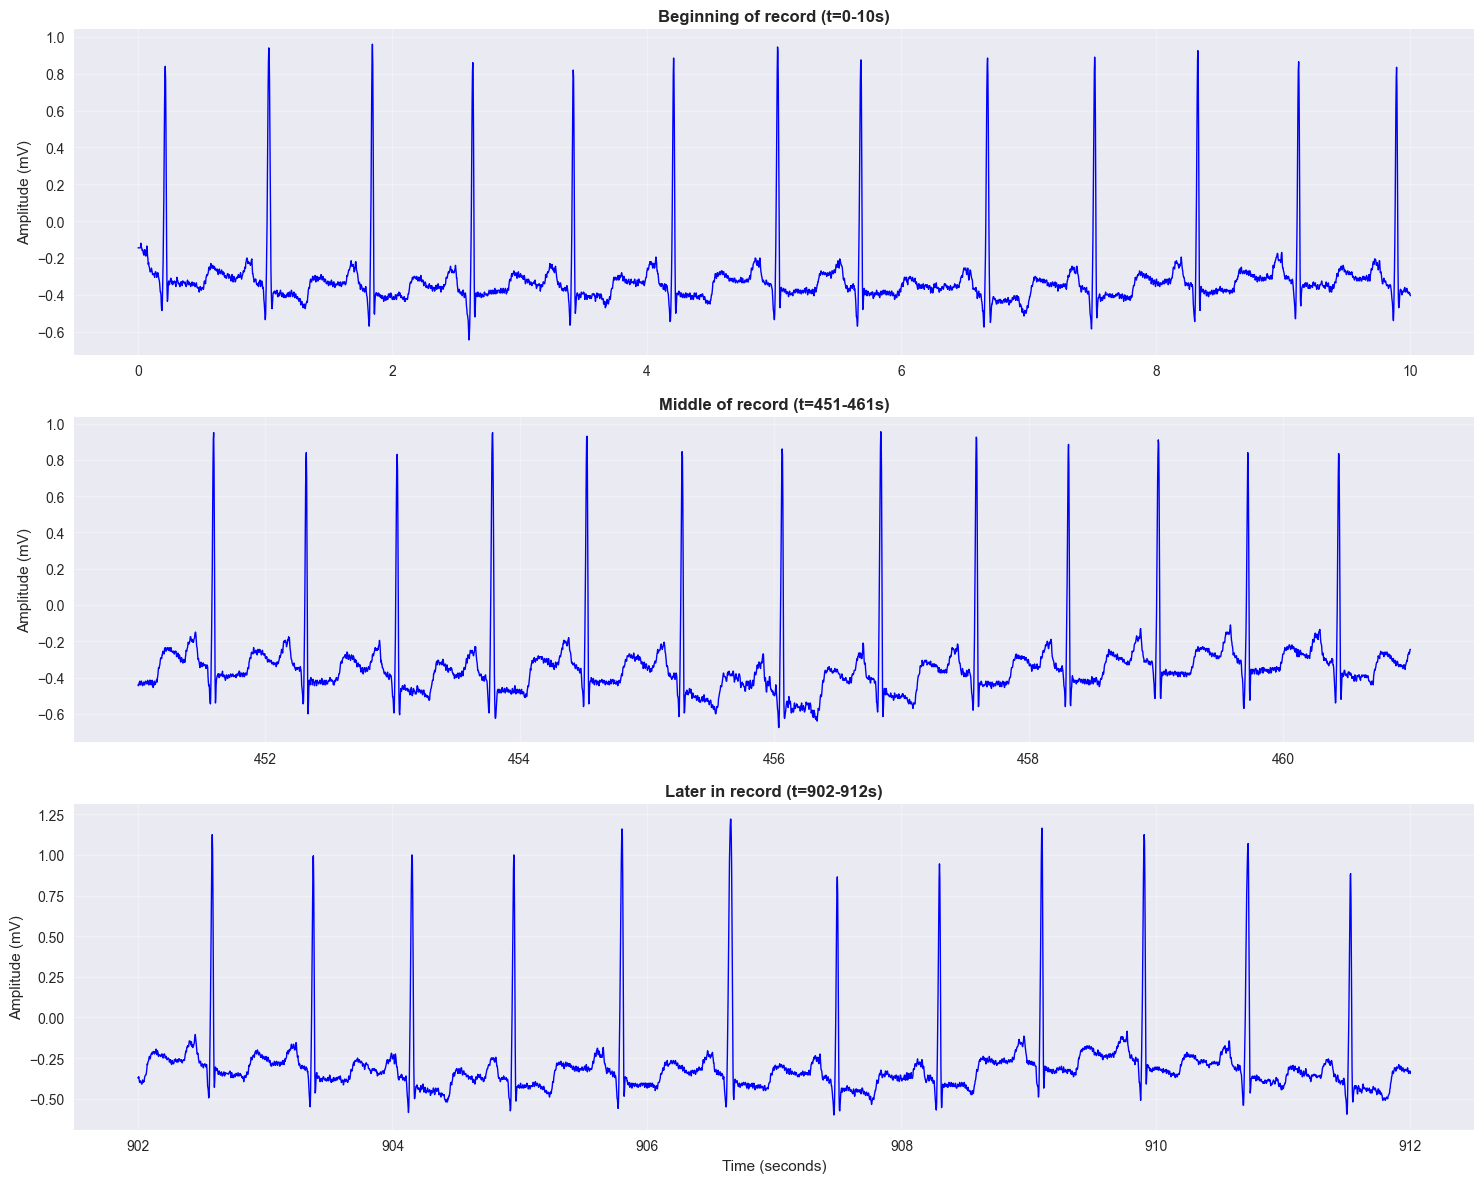

In [7]:
# Plot multiple segments to show different parts of the signal
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

segments = [
    (0, 10, "Beginning of record"),
    (len(signals)//4//record.fs, 10, "Middle of record"),
    (len(signals)//2//record.fs, 10, "Later in record")
]

for i, (start_time, duration, title) in enumerate(segments):
    start_idx = int(start_time * record.fs)
    end_idx = int((start_time + duration) * record.fs)
    
    if end_idx > len(signals):
        end_idx = len(signals)
    
    segment = signals[start_idx:end_idx, 0]
    time_axis = np.linspace(start_time, start_time + len(segment)/record.fs, len(segment))
    
    axes[i].plot(time_axis, segment, 'b-', linewidth=1)
    axes[i].set_title(f"{title} (t={start_time}-{start_time+duration}s)", fontweight='bold')
    axes[i].set_ylabel('Amplitude (mV)')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

## 3. Beat Annotation Analysis

📝 Beat Annotation Analysis:
   Total annotations: 2274
   Beat type counts:
     +: 1
     A: 33
     N: 2239
     V: 1


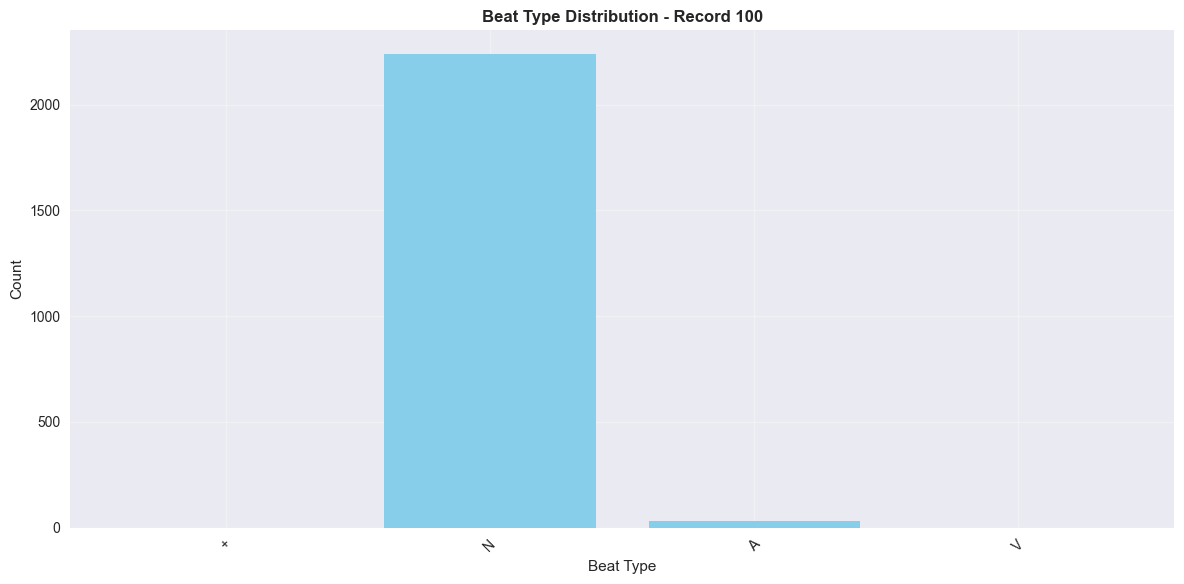

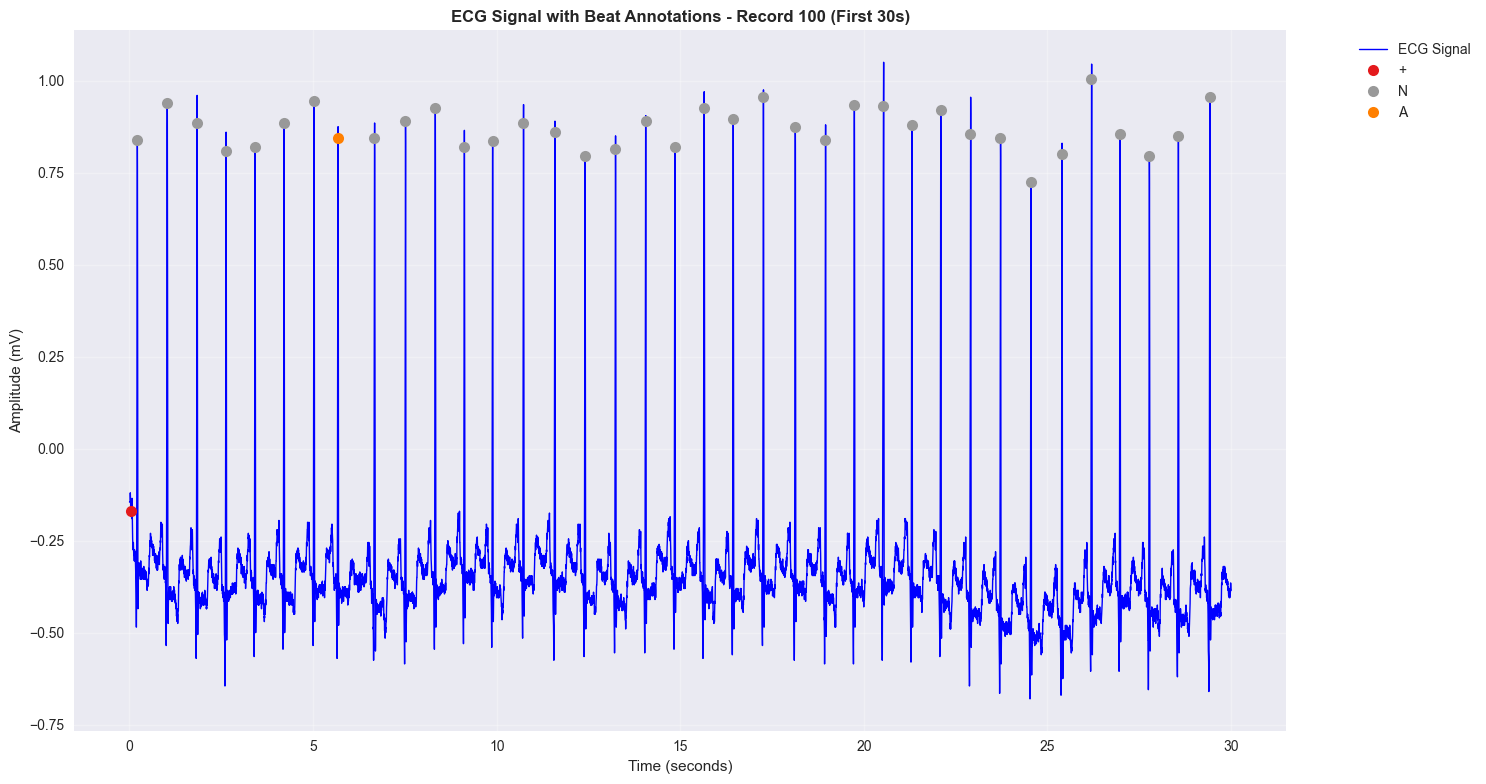

In [15]:
# Analyze beat annotations
if hasattr(annotations, 'symbol') and len(annotations.symbol) > 0:
    print(f"📝 Beat Annotation Analysis:")
    print(f"   Total annotations: {len(annotations.symbol)}")
    
    # Count beat types
    beat_counts = {}
    for symbol in annotations.symbol:
        beat_counts[symbol] = beat_counts.get(symbol, 0) + 1
    
    print(f"   Beat type counts:")
    for beat_type, count in sorted(beat_counts.items()):
        print(f"     {beat_type}: {count}")
    
    # Plot beat type distribution
    plt.figure(figsize=(12, 6))
    plt.bar(beat_counts.keys(), beat_counts.values(), color='skyblue')
    plt.title(f'Beat Type Distribution - Record {record_name}', fontweight='bold')
    plt.xlabel('Beat Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot annotations on signal (first 30 seconds)
    duration = 30  # seconds
    end_idx = min(duration * record.fs, len(signals))
    
    segment = signals[:end_idx, 0]
    time_axis = np.linspace(0, duration, len(segment))
    
    samples_np = np.array(annotations.sample)
    symbols_np = np.array(annotations.symbol)

    segment_mask = samples_np < end_idx
    segment_ann_samples = samples_np[segment_mask]
    segment_ann_symbols = symbols_np[segment_mask]


    # # Find annotations in this segment
    # segment_mask = annotations.sample < end_idx
    # segment_ann_samples = annotations.sample[segment_mask]
    # segment_ann_symbols = annotations.symbol[segment_mask]
    
    plt.figure(figsize=(15, 8))
    plt.plot(time_axis, segment, 'b-', linewidth=1, label='ECG Signal')
    
    if len(segment_ann_samples) > 0:
        ann_times = segment_ann_samples / record.fs
        ann_values = segment[segment_ann_samples]
        
        # Color code different beat types
        colors = plt.cm.Set1(np.linspace(0, 1, len(set(segment_ann_symbols))))
        color_map = dict(zip(set(segment_ann_symbols), colors))
        
        for i, (time, value, symbol) in enumerate(zip(ann_times, ann_values, segment_ann_symbols)):
            plt.plot(time, value, 'o', color=color_map[symbol], markersize=8, 
                    label=symbol if symbol not in [l.get_label() for l in plt.gca().get_legend_handles_labels()[0]] else "")
    
    plt.title(f'ECG Signal with Beat Annotations - Record {record_name} (First 30s)', fontweight='bold')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (mV)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️  No beat annotations available for this record")

## 4. Signal Statistics and Analysis

📊 Signal Statistics:
   Mean: -0.3063
   Std: 0.1932
   Min: -2.7150
   Max: 1.4350
   Range: 4.1500
   Skewness: 4.4261
   Kurtosis: 25.4131


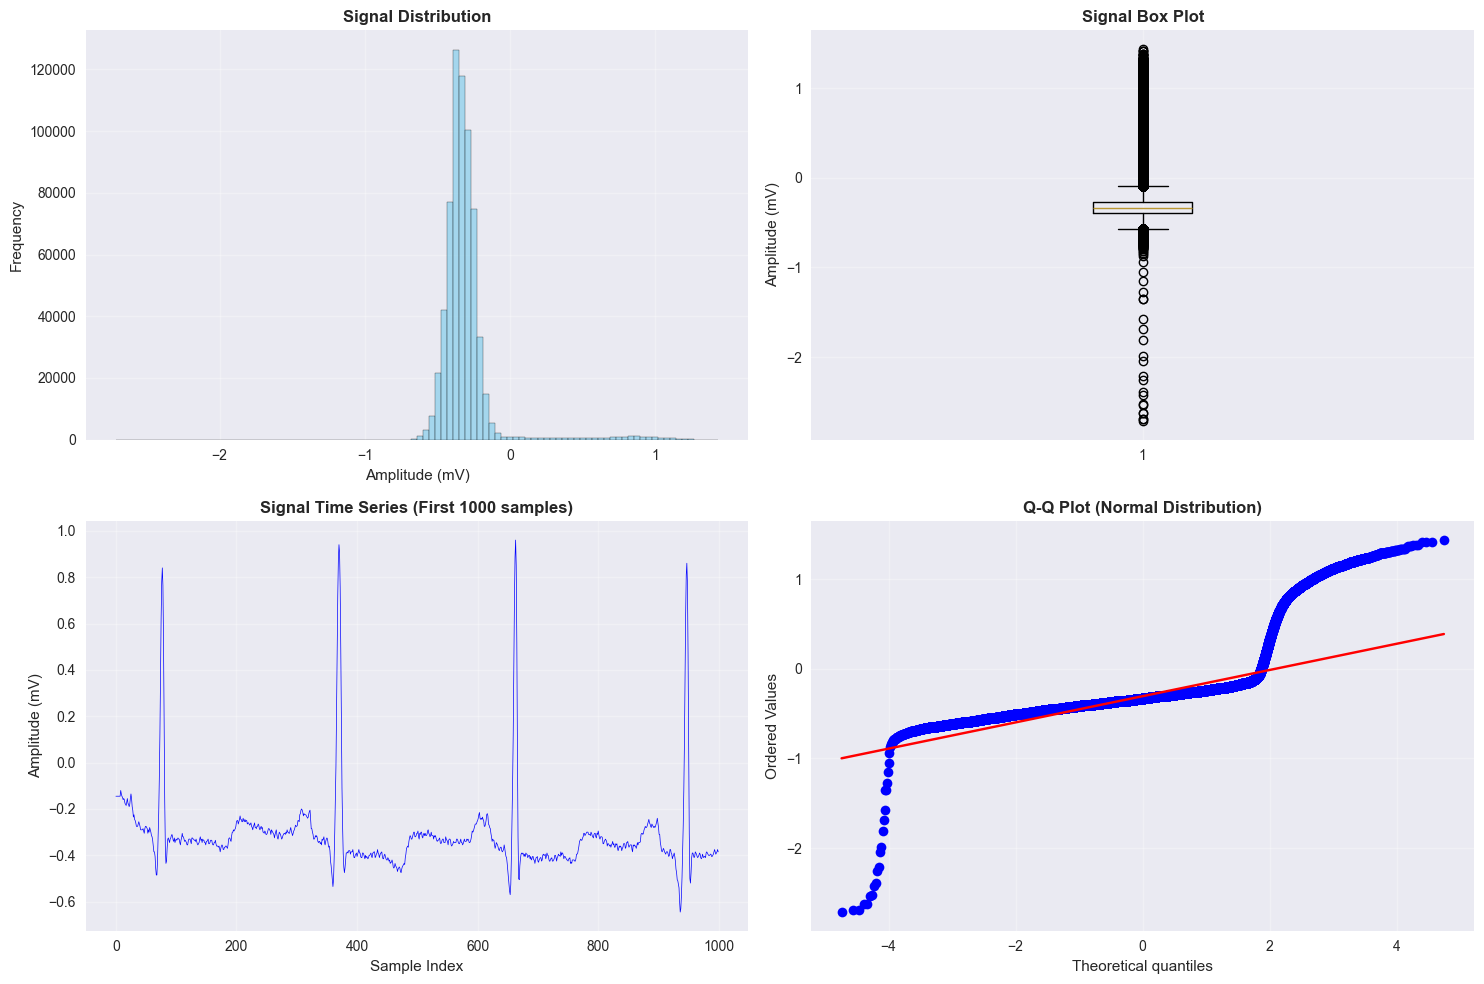

In [9]:
# Calculate basic statistics
ecg_signal = signals[:, 0]

stats = {
    'Mean': np.mean(ecg_signal),
    'Std': np.std(ecg_signal),
    'Min': np.min(ecg_signal),
    'Max': np.max(ecg_signal),
    'Range': np.max(ecg_signal) - np.min(ecg_signal),
    'Skewness': scipy.stats.skew(ecg_signal),
    'Kurtosis': scipy.stats.kurtosis(ecg_signal)
}

print("📊 Signal Statistics:")
for stat, value in stats.items():
    print(f"   {stat}: {value:.4f}")

# Create statistics visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(ecg_signal, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Signal Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Amplitude (mV)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Box plot
axes[0, 1].boxplot(ecg_signal, vert=True)
axes[0, 1].set_title('Signal Box Plot', fontweight='bold')
axes[0, 1].set_ylabel('Amplitude (mV)')
axes[0, 1].grid(True, alpha=0.3)

# Time series plot (first 1000 samples)
sample_range = min(1000, len(ecg_signal))
axes[1, 0].plot(ecg_signal[:sample_range], 'b-', linewidth=0.5)
axes[1, 0].set_title('Signal Time Series (First 1000 samples)', fontweight='bold')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Amplitude (mV)')
axes[1, 0].grid(True, alpha=0.3)

# Q-Q plot
from scipy.stats import probplot
probplot(ecg_signal, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normal Distribution)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Frequency Domain Analysis

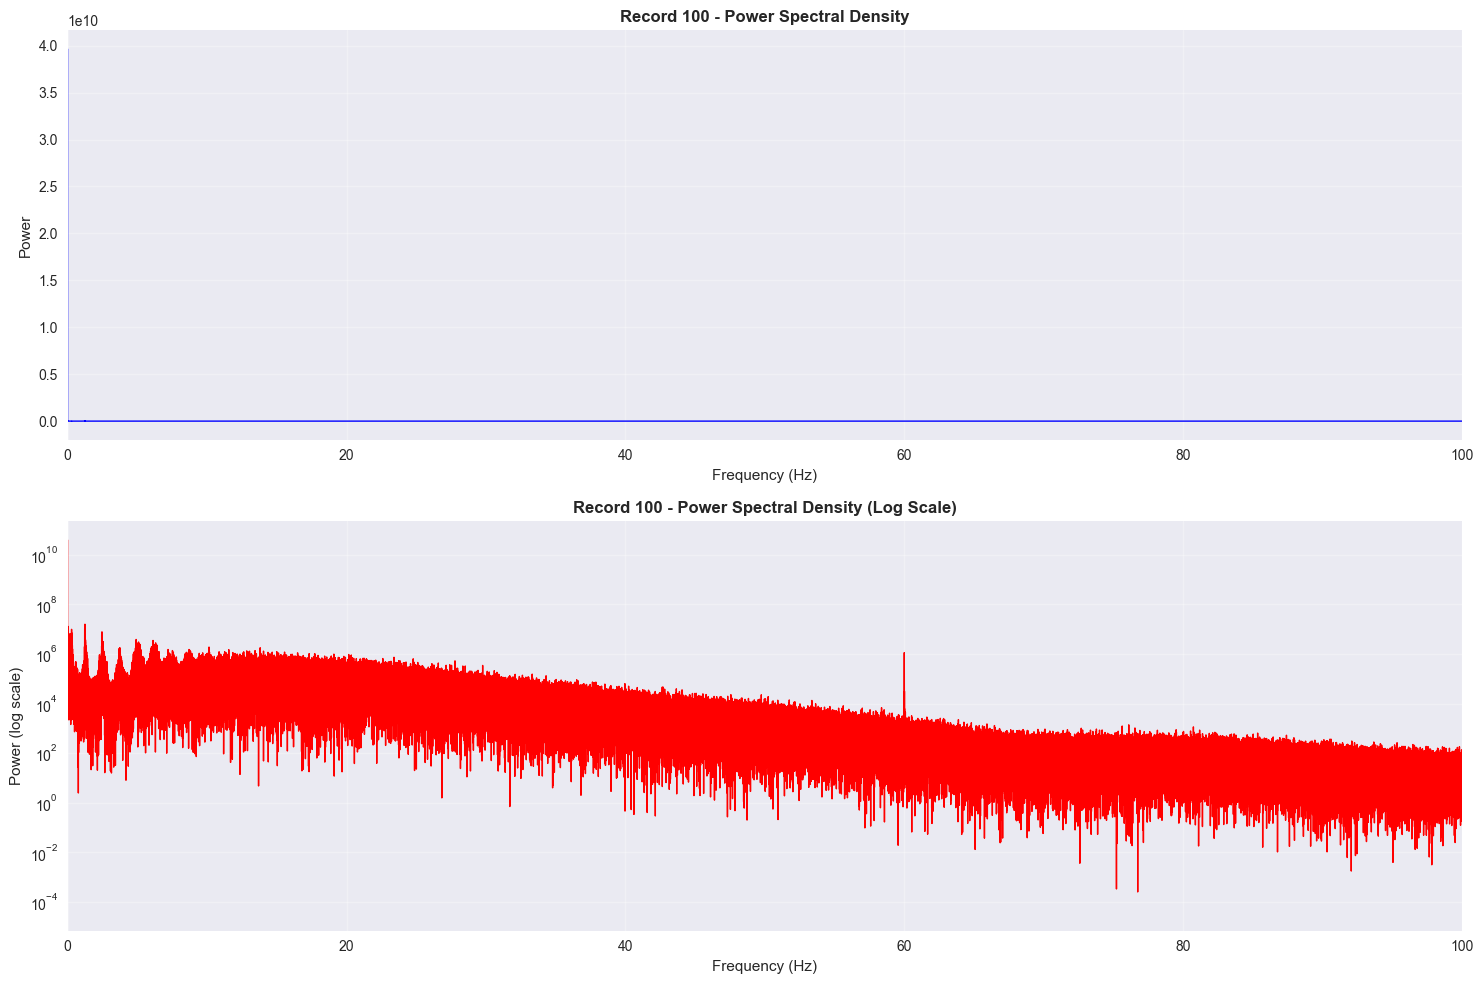

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [10]:
# Frequency domain analysis
def analyze_frequency_domain(signal, fs, title="Frequency Domain Analysis"):
    """
    Analyze signal in frequency domain.
    """
    # Compute FFT
    n = len(signal)
    fft_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, 1/fs)
    
    # Power spectral density
    psd = np.abs(fft_signal) ** 2
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # FFT magnitude
    positive_freqs = freqs[:n//2]
    positive_psd = psd[:n//2]
    
    axes[0].plot(positive_freqs, positive_psd, 'b-', linewidth=1)
    axes[0].set_title(f'{title} - Power Spectral Density', fontweight='bold')
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Power')
    axes[0].set_xlim(0, 100)  # Focus on relevant frequencies for MIT-BIH
    axes[0].grid(True, alpha=0.3)
    
    # Log scale for better visualization
    axes[1].semilogy(positive_freqs, positive_psd, 'r-', linewidth=1)
    axes[1].set_title(f'{title} - Power Spectral Density (Log Scale)', fontweight='bold')
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('Power (log scale)')
    axes[1].set_xlim(0, 100)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print dominant frequencies
    peak_freqs = positive_freqs[np.argsort(positive_psd)[-5:]]
    print(f"🔍 Top 5 dominant frequencies: {peak_freqs[::-1]:.2f} Hz")

# Analyze frequency domain
analyze_frequency_domain(ecg_signal, record.fs, f"Record {record_name}")

## 6. R-Peak Detection and Heart Rate Analysis

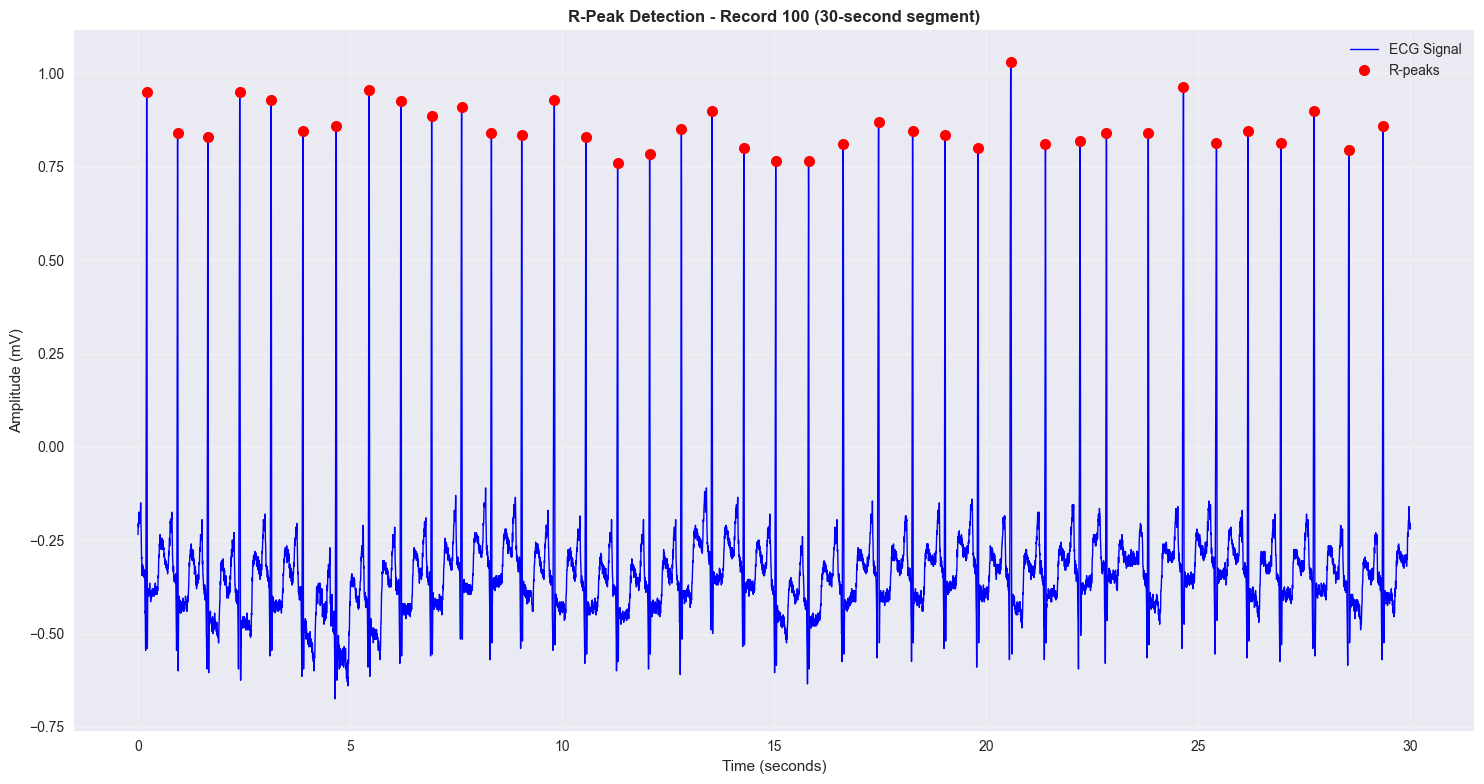

💓 Heart Rate Analysis:
   Number of R-peaks detected: 39
   Mean heart rate: 78.6 BPM
   Std heart rate: 5.4 BPM
   Min heart rate: 60.8 BPM
   Max heart rate: 96.9 BPM


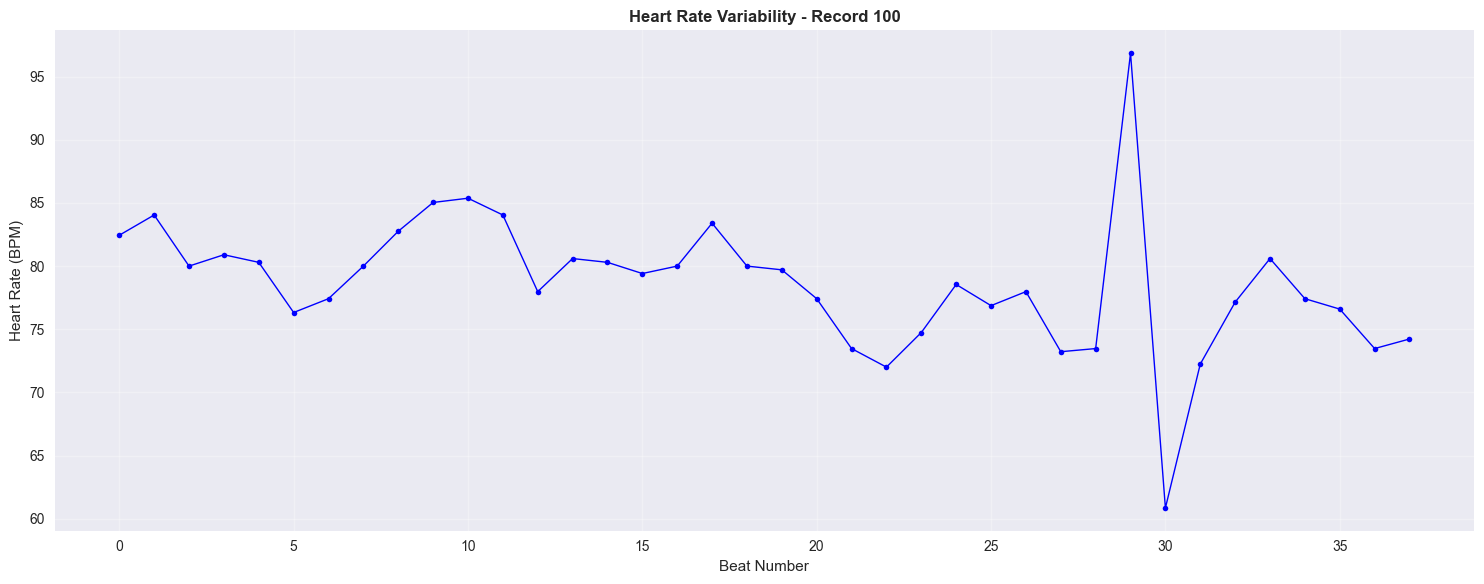

In [11]:
# Simple R-peak detection using scipy
def detect_r_peaks(signal, fs, distance=200):
    """
    Detect R-peaks in ECG signal.
    """
    from scipy.signal import find_peaks
    
    # Find peaks
    peaks, _ = find_peaks(signal, distance=distance, height=np.std(signal))
    
    return peaks

# Detect R-peaks in a segment
segment_duration = 30  # seconds
segment_start = len(signals) // 4  # Start from 1/4 of the signal
segment_end = segment_start + int(segment_duration * record.fs)

if segment_end > len(signals):
    segment_end = len(signals)

segment = signals[segment_start:segment_end, 0]
r_peaks = detect_r_peaks(segment, record.fs)

# Plot segment with R-peaks
time_axis = np.linspace(0, len(segment)/record.fs, len(segment))

plt.figure(figsize=(15, 8))
plt.plot(time_axis, segment, 'b-', linewidth=1, label='ECG Signal')
plt.plot(time_axis[r_peaks], segment[r_peaks], 'ro', markersize=8, label='R-peaks')
plt.title(f'R-Peak Detection - Record {record_name} (30-second segment)', fontweight='bold')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate heart rate statistics
if len(r_peaks) > 1:
    rr_intervals = np.diff(r_peaks) / record.fs  # Convert to seconds
    heart_rates = 60 / rr_intervals  # Convert to BPM
    
    print(f"💓 Heart Rate Analysis:")
    print(f"   Number of R-peaks detected: {len(r_peaks)}")
    print(f"   Mean heart rate: {np.mean(heart_rates):.1f} BPM")
    print(f"   Std heart rate: {np.std(heart_rates):.1f} BPM")
    print(f"   Min heart rate: {np.min(heart_rates):.1f} BPM")
    print(f"   Max heart rate: {np.max(heart_rates):.1f} BPM")
    
    # Plot heart rate variability
    plt.figure(figsize=(15, 6))
    plt.plot(heart_rates, 'b-o', linewidth=1, markersize=4)
    plt.title(f'Heart Rate Variability - Record {record_name}', fontweight='bold')
    plt.xlabel('Beat Number')
    plt.ylabel('Heart Rate (BPM)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Not enough R-peaks detected for heart rate analysis")

## 7. Beat Type Analysis

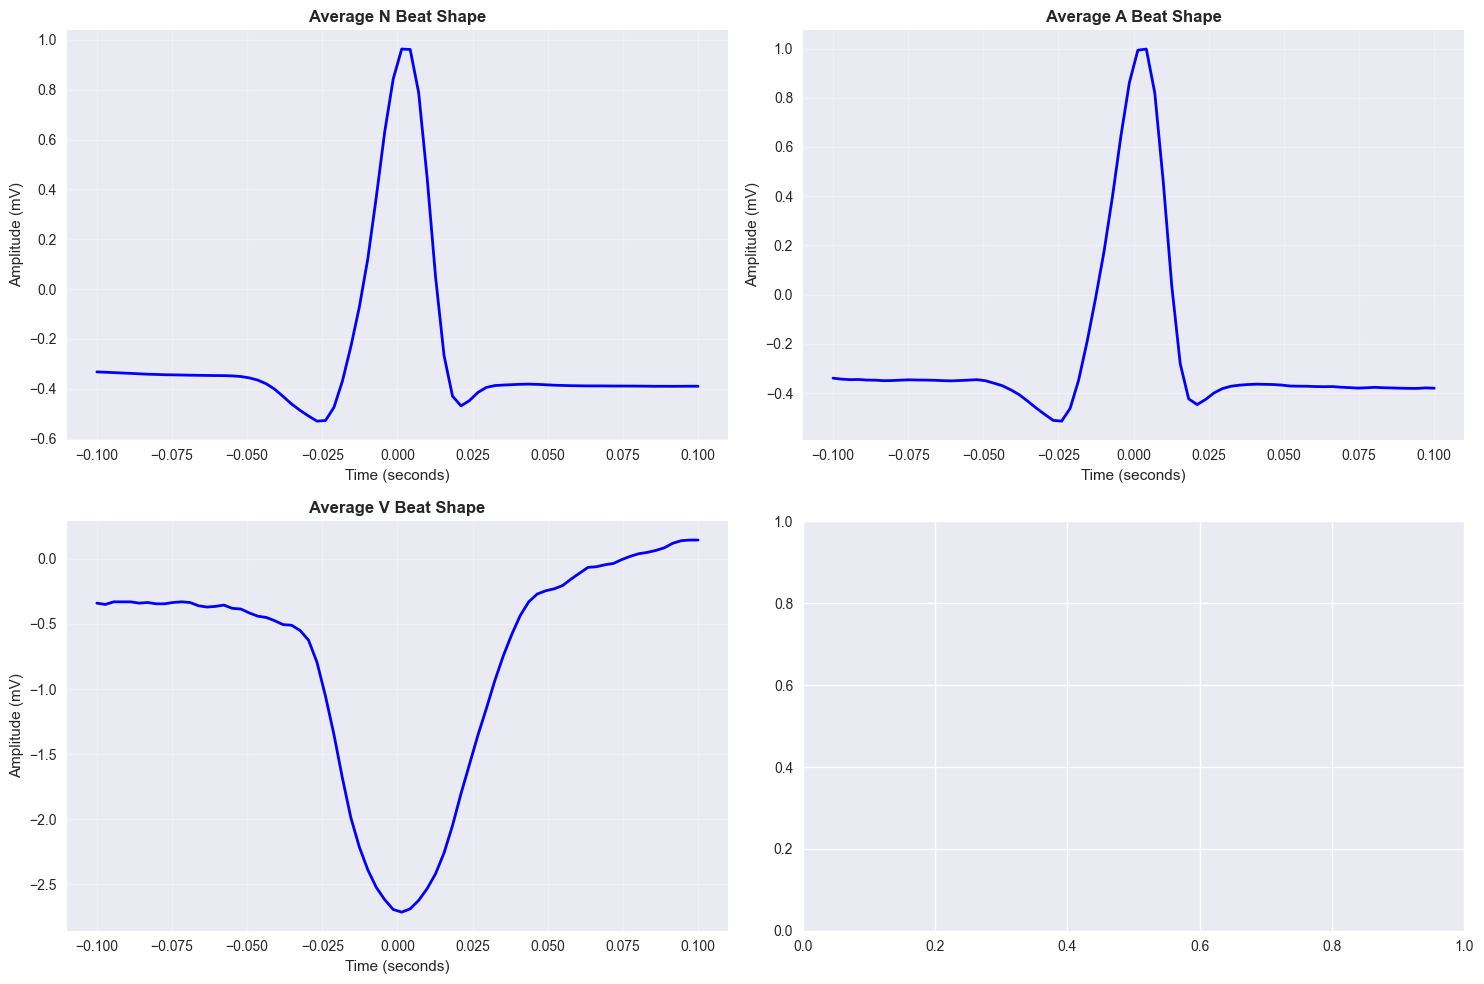

📊 Beat Type Characteristics:
   N (n=2238):
     Mean amplitude: -0.2596 mV
     Std amplitude: 0.3415 mV
     Max amplitude: 0.9633 mV
     Min amplitude: -0.5299 mV
   A (n=33):
     Mean amplitude: -0.2479 mV
     Std amplitude: 0.3460 mV
     Max amplitude: 0.9979 mV
     Min amplitude: -0.5136 mV
   V (n=1):
     Mean amplitude: -0.7830 mV
     Std amplitude: 0.8817 mV
     Max amplitude: 0.1450 mV
     Min amplitude: -2.7150 mV


In [12]:
# Analyze different beat types if annotations are available
if hasattr(annotations, 'symbol') and len(annotations.symbol) > 0:
    # Extract beat segments around annotations
    beat_window = int(0.2 * record.fs)  # 200ms window around each beat
    beat_segments = {}
    
    for i, (sample, symbol) in enumerate(zip(annotations.sample, annotations.symbol)):
        start_idx = max(0, sample - beat_window // 2)
        end_idx = min(len(signals), sample + beat_window // 2)
        
        if end_idx - start_idx == beat_window:  # Only use complete segments
            segment = signals[start_idx:end_idx, 0]
            
            if symbol not in beat_segments:
                beat_segments[symbol] = []
            beat_segments[symbol].append(segment)
    
    # Plot average beat shapes for different types
    if len(beat_segments) > 1:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, (beat_type, segments) in enumerate(list(beat_segments.items())[:4]):
            if i < len(axes):
                avg_beat = np.mean(segments, axis=0)
                time_axis = np.linspace(-0.1, 0.1, len(avg_beat))
                
                axes[i].plot(time_axis, avg_beat, 'b-', linewidth=2)
                axes[i].set_title(f'Average {beat_type} Beat Shape', fontweight='bold')
                axes[i].set_xlabel('Time (seconds)')
                axes[i].set_ylabel('Amplitude (mV)')
                axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Compare beat characteristics
        beat_stats = {}
        for beat_type, segments in beat_segments.items():
            if len(segments) > 0:
                avg_beat = np.mean(segments, axis=0)
                beat_stats[beat_type] = {
                    'count': len(segments),
                    'mean_amplitude': np.mean(avg_beat),
                    'std_amplitude': np.std(avg_beat),
                    'max_amplitude': np.max(avg_beat),
                    'min_amplitude': np.min(avg_beat)
                }
        
        print("📊 Beat Type Characteristics:")
        for beat_type, stats in beat_stats.items():
            print(f"   {beat_type} (n={stats['count']}):")
            print(f"     Mean amplitude: {stats['mean_amplitude']:.4f} mV")
            print(f"     Std amplitude: {stats['std_amplitude']:.4f} mV")
            print(f"     Max amplitude: {stats['max_amplitude']:.4f} mV")
            print(f"     Min amplitude: {stats['min_amplitude']:.4f} mV")
else:
    print("⚠️  No beat annotations available for beat type analysis")

## 8. Summary and Next Steps

In [13]:
# Summary statistics
print("📋 Dataset Summary:")
print(f"   Record: {record_name}")
print(f"   Duration: {len(signals) / record.fs / 60:.1f} minutes")
print(f"   Sampling rate: {record.fs} Hz")
print(f"   Total samples: {len(signals):,}")
print(f"   Signal range: {np.min(ecg_signal):.3f} to {np.max(ecg_signal):.3f} mV")
print(f"   Signal mean: {np.mean(ecg_signal):.3f} mV")
print(f"   Signal std: {np.std(ecg_signal):.3f} mV")

if 'r_peaks' in locals() and len(r_peaks) > 1:
    print(f"   Estimated heart rate: {np.mean(heart_rates):.1f} ± {np.std(heart_rates):.1f} BPM")

if hasattr(annotations, 'symbol') and len(annotations.symbol) > 0:
    unique_beats = set(annotations.symbol)
    print(f"   Beat types found: {', '.join(sorted(unique_beats))}")

print("\n🎯 Key Observations:")
print("   • ECG signal shows typical cardiac morphology")
print("   • R-peaks are clearly identifiable")
print("   • Signal contains baseline wander and noise")
print("   • Frequency content is primarily below 100 Hz")
print("   • Different beat types show distinct morphological patterns")

print("\n📈 Next Steps:")
print("   • Load multiple records to compare different arrhythmia types")
print("   • Implement more robust R-peak detection")
print("   • Extract features for beat classification")
print("   • Analyze arrhythmia patterns and transitions")
print("   • Prepare data for machine learning models")
print("   • Compare with AFDB dataset characteristics")

📋 Dataset Summary:
   Record: 100
   Duration: 30.1 minutes
   Sampling rate: 360 Hz
   Total samples: 650,000
   Signal range: -2.715 to 1.435 mV
   Signal mean: -0.306 mV
   Signal std: 0.193 mV
   Estimated heart rate: 78.6 ± 5.4 BPM
   Beat types found: +, A, N, V

🎯 Key Observations:
   • ECG signal shows typical cardiac morphology
   • R-peaks are clearly identifiable
   • Signal contains baseline wander and noise
   • Frequency content is primarily below 100 Hz
   • Different beat types show distinct morphological patterns

📈 Next Steps:
   • Load multiple records to compare different arrhythmia types
   • Implement more robust R-peak detection
   • Extract features for beat classification
   • Analyze arrhythmia patterns and transitions
   • Prepare data for machine learning models
   • Compare with AFDB dataset characteristics


## 9. Save Analysis Results

In [ ]:
# Save analysis results
import json
import os

# Create output directory
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Save statistics
results = {
    'record_name': record_name,
    'duration_minutes': len(signals) / record.fs / 60,
    'sampling_rate': record.fs,
    'total_samples': len(signals),
    'signal_stats': stats,
    'analysis_timestamp': pd.Timestamp.now().isoformat()
}

# Add beat statistics if available
if hasattr(annotations, 'symbol') and len(annotations.symbol) > 0:
    beat_counts = {}
    for symbol in annotations.symbol:
        beat_counts[symbol] = beat_counts.get(symbol, 0) + 1
    results['beat_counts'] = beat_counts

# Add heart rate statistics if available
if 'r_peaks' in locals() and len(r_peaks) > 1:
    results['heart_rate_stats'] = {
        'mean_hr': float(np.mean(heart_rates)),
        'std_hr': float(np.std(heart_rates)),
        'min_hr': float(np.min(heart_rates)),
        'max_hr': float(np.max(heart_rates))
    }

# Save to JSON file
with open(f"{output_dir}/{record_name}_analysis.json", 'w') as f:
    json.dump(results, f, indent=2)

print(f"✅ Analysis results saved to {output_dir}/{record_name}_analysis.json")